In [19]:
# Import Necessary Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from tensorflow.keras import layers, models

In [20]:
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Define Paths
base_dir = "/content/drive/My Drive/ml_project/Dataset"
output_dir = "/content/drive/My Drive/ml_project/vehicle_split_dataset"

In [22]:
# Function to create directories
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [23]:
# Create Output Directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    create_dir(split)

In [24]:
# Split Dataset into train, val, and test sets
from sklearn.model_selection import train_test_split
import shutil

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        # Splitting data

        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

        for split_name, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            create_dir(split_class_dir)

            # Get the number of images in the current split
            num_images = len(split_imgs)

            print(f"{split_name.capitalize()} - {class_name}: {num_images} images")

            for img_name in split_imgs:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_class_dir, img_name)
                shutil.copy(src, dst)

print("Dataset splitting completed!")

Train - Bus: 70 images
Val - Bus: 20 images
Test - Bus: 10 images
Train - Car: 70 images
Val - Car: 20 images
Test - Car: 10 images
Train - motorcycle: 70 images
Val - motorcycle: 20 images
Test - motorcycle: 10 images
Train - Truck: 70 images
Val - Truck: 20 images
Test - Truck: 10 images
Dataset splitting completed!


In [25]:
# Load Data
import cv2
import numpy as np

def load_images_and_labels(base_dir):
    images = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(os.listdir(base_dir))}

    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label_map[label])
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_and_labels(train_dir)
val_images, val_labels = load_images_and_labels(val_dir)
test_images, test_labels = load_images_and_labels(test_dir)


In [26]:
# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data generator

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 280 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [27]:
# Define the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import tensorflow as tf


model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,940,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,313,796 (73.68 MB)

 Trainable params: 19,312,900 (73.67 MB)

 Non-trainable params: 896 (3.50 KB)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10, Validation Loss: 1.8959, Validation Accuracy: 0.2969
Epoch 2/10, Validation Loss: 2.8094, Validation Accuracy: 0.2500
Epoch 3/10, Validation Loss: 4.6420, Validation Accuracy: 0.2969
Epoch 4/10, Validation Loss: 6.9831, Validation Accuracy: 0.2656
Epoch 5/10, Validation Loss: 9.6247, Validation Accuracy: 0.2188
Epoch 6/10, Validation Loss: 11.0167, Validation Accuracy: 0.2344
Epoch 7/10, Validation Loss: 11.6352, Validation Accuracy: 0.2656
Epoch 8/10, Validation Loss: 13.6228, Validation Accuracy: 0.2188
Epoch 9/10, Validation Loss: 13.5290, Validation Accuracy: 0.2656
Epoch 10/10, Validation Loss: 15.3997, Validation Accuracy: 0.2500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.2708 - loss: 15.4647
Test Loss: 15.4932
Test Accuracy: 0.2500


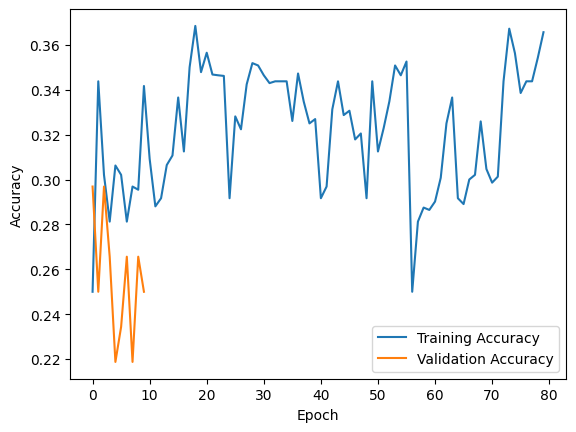

In [28]:
# Train the model
epochs = 10

history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(epochs):

    for batch_index in range(train_generator.samples // batch_size):

        X_batch, y_batch = next(train_generator)
        loss = model.train_on_batch(X_batch, y_batch)
        history['loss'].append(loss[0])
        history['accuracy'].append(loss[1])

    # Evaluate on validation data
    val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=0)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early stopping check
    if early_stopping.model is None or val_loss < early_stopping.best:
        early_stopping.best = val_loss
        early_stopping.wait = 0
    else:
        early_stopping.wait += 1
        if early_stopping.wait >= early_stopping.patience:
            print("Early stopping triggered.")
            break

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
              precision    recall  f1-score   support

         Bus       0.00      0.00      0.00        10
         Car       0.00      0.00      0.00        10
       Truck       0.25      1.00      0.40        10
  motorcycle       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Conventional ML (HOG + SVM)
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert the image to uint8 before color conversion
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feature, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(feature)
    return np.array(hog_features)

train_hog_features = extract_hog_features(train_images)
val_hog_features = extract_hog_features(val_images)

In [31]:
# Train SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_hog_features, train_labels)

SVC(kernel='linear', random_state=42)

In [32]:
# Evaluate SVM
val_predictions = svm_model.predict(val_hog_features)
svm_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy (SVM): {svm_accuracy:.2f}")
print(classification_report(val_labels, val_predictions))

Validation Accuracy (SVM): 0.71
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.73      0.80      0.76        20
           2       1.00      0.90      0.95        20
           3       0.55      0.60      0.57        20

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.71        80
weighted avg       0.72      0.71      0.71        80

